# DINOv2 Complete Data Pipeline Debugging

This notebook debugs the COMPLETE data pipeline from S3 to model input, including:
1. Original 256x256 slides from S3
2. Data augmentation (global/local crops + color transforms)
3. **iBOT masking** (missing from original notebook)
4. **Collation and casting** to torch.half (missing from original notebook)
5. Visualization of final tensors that enter the model

This matches the exact pipeline used in training with config: `vits14_reg4.yaml`

In [6]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import litdata as ld
from torchvision import transforms
from functools import partial

# Add the project root to path
sys.path.append('/home/paul/path-fm')

from dinov2.data.augmentations import DataAugmentationDINO
from dinov2.data import MaskingGenerator, collate_data_and_cast

# Load and merge config values (from vits14_reg4.yaml + ssl_default_config.yaml)
CONFIG = {
    # From vits14_reg4.yaml
    'patch_size': 14,
    'local_crops_size': 98,
    
    # From ssl_default_config.yaml  
    'global_crops_scale': [0.32, 1.0],
    'local_crops_scale': [0.05, 0.32], 
    'local_crops_number': 8,
    'global_crops_size': 224,
    'mask_sample_probability': 0.5,
    'mask_ratio_min_max': [0.1, 0.5],
    'inputs_dtype': torch.half,  # fp16 from mixed precision config
}

# Set up storage options for litData
storage_options = {
    "endpoint_url": os.environ.get("AWS_ENDPOINT_URL"),
    "aws_access_key_id": os.environ.get("AWS_ACCESS_KEY_ID"),
    "aws_secret_access_key": os.environ.get("AWS_SECRET_ACCESS_KEY"),
}

print("Environment setup complete")
print(f"Using config: patch_size={CONFIG['patch_size']}, local_crops_size={CONFIG['local_crops_size']}")

Environment setup complete
Using config: patch_size=14, local_crops_size=98


In [7]:
# Set up the COMPLETE data pipeline exactly as in training

# 1. Data augmentation pipeline
data_transform = DataAugmentationDINO(
    global_crops_scale=CONFIG['global_crops_scale'],
    local_crops_scale=CONFIG['local_crops_scale'],
    local_crops_number=CONFIG['local_crops_number'],
    global_crops_size=CONFIG['global_crops_size'],
    local_crops_size=CONFIG['local_crops_size']
)

# 2. Masking generator (for iBOT)
img_size = CONFIG['global_crops_size']
patch_size = CONFIG['patch_size']
n_tokens = (img_size // patch_size) ** 2

mask_generator = MaskingGenerator(
    input_size=(img_size // patch_size, img_size // patch_size),
    max_num_patches=0.5 * img_size // patch_size * img_size // patch_size,
)

# 3. Collate function (combines masking + casting)
collate_fn = partial(
    collate_data_and_cast,
    mask_ratio_tuple=CONFIG['mask_ratio_min_max'],
    mask_probability=CONFIG['mask_sample_probability'],
    n_tokens=n_tokens,
    mask_generator=mask_generator,
    dtype=CONFIG['inputs_dtype'],
)

# 4. Extract and transform function
def extract_and_transform(item):
    transformed = data_transform(item['image'])
    return (transformed, None)

print("Complete pipeline setup:")
print(f"  - n_tokens (patches): {n_tokens}")
print(f"  - mask_ratio_range: {CONFIG['mask_ratio_min_max']}")
print(f"  - mask_probability: {CONFIG['mask_sample_probability']}")
print(f"  - dtype: {CONFIG['inputs_dtype']}")

Complete pipeline setup:
  - n_tokens (patches): 256
  - mask_ratio_range: [0.1, 0.5]
  - mask_probability: 0.5
  - dtype: torch.float16


In [8]:
# Load data exactly as in training (with correct shuffle/drop_last settings)
dataset = ld.StreamingDataset(
    's3://sophont/paul/data/litTCGA', 
    storage_options=storage_options, 
    shuffle=True,      # Match training
    drop_last=True,    # Match training
    transform=extract_and_transform  # Apply the transform in the dataset
)

# Create dataloader with proper collate function
data_loader = ld.StreamingDataLoader(dataset, collate_fn=collate_fn)

# Get one batch - this now goes through the COMPLETE pipeline
batch = next(iter(data_loader))

print("=== BATCH STRUCTURE AFTER COMPLETE PIPELINE ===")
print(f"Batch keys: {list(batch.keys())}")
print(f"Batch types: {[(k, type(v)) for k, v in batch.items()]}")

if 'collated_global_crops' in batch:
    print(f"Global crops shape: {batch['collated_global_crops'].shape}")
    print(f"Global crops dtype: {batch['collated_global_crops'].dtype}")

if 'collated_local_crops' in batch:
    print(f"Local crops shape: {batch['collated_local_crops'].shape}")  
    print(f"Local crops dtype: {batch['collated_local_crops'].dtype}")

if 'collated_masks' in batch:
    print(f"Masks shape: {batch['collated_masks'].shape}")
    print(f"Masks dtype: {batch['collated_masks'].dtype}")
    print(f"Masks range: [{batch['collated_masks'].min():.3f}, {batch['collated_masks'].max():.3f}]")

=== BATCH STRUCTURE AFTER COMPLETE PIPELINE ===
Batch keys: ['collated_global_crops', 'collated_local_crops', 'collated_masks', 'mask_indices_list', 'masks_weight', 'upperbound', 'n_masked_patches']
Batch types: [('collated_global_crops', <class 'torch.Tensor'>), ('collated_local_crops', <class 'torch.Tensor'>), ('collated_masks', <class 'torch.Tensor'>), ('mask_indices_list', <class 'torch.Tensor'>), ('masks_weight', <class 'torch.Tensor'>), ('upperbound', <class 'int'>), ('n_masked_patches', <class 'torch.Tensor'>)]
Global crops shape: torch.Size([2, 3, 224, 224])
Global crops dtype: torch.float16
Local crops shape: torch.Size([8, 3, 98, 98])
Local crops dtype: torch.float16
Masks shape: torch.Size([2, 256])
Masks dtype: torch.bool
Masks range: [0.000, 1.000]


=== RAW IMAGES FROM S3 ===


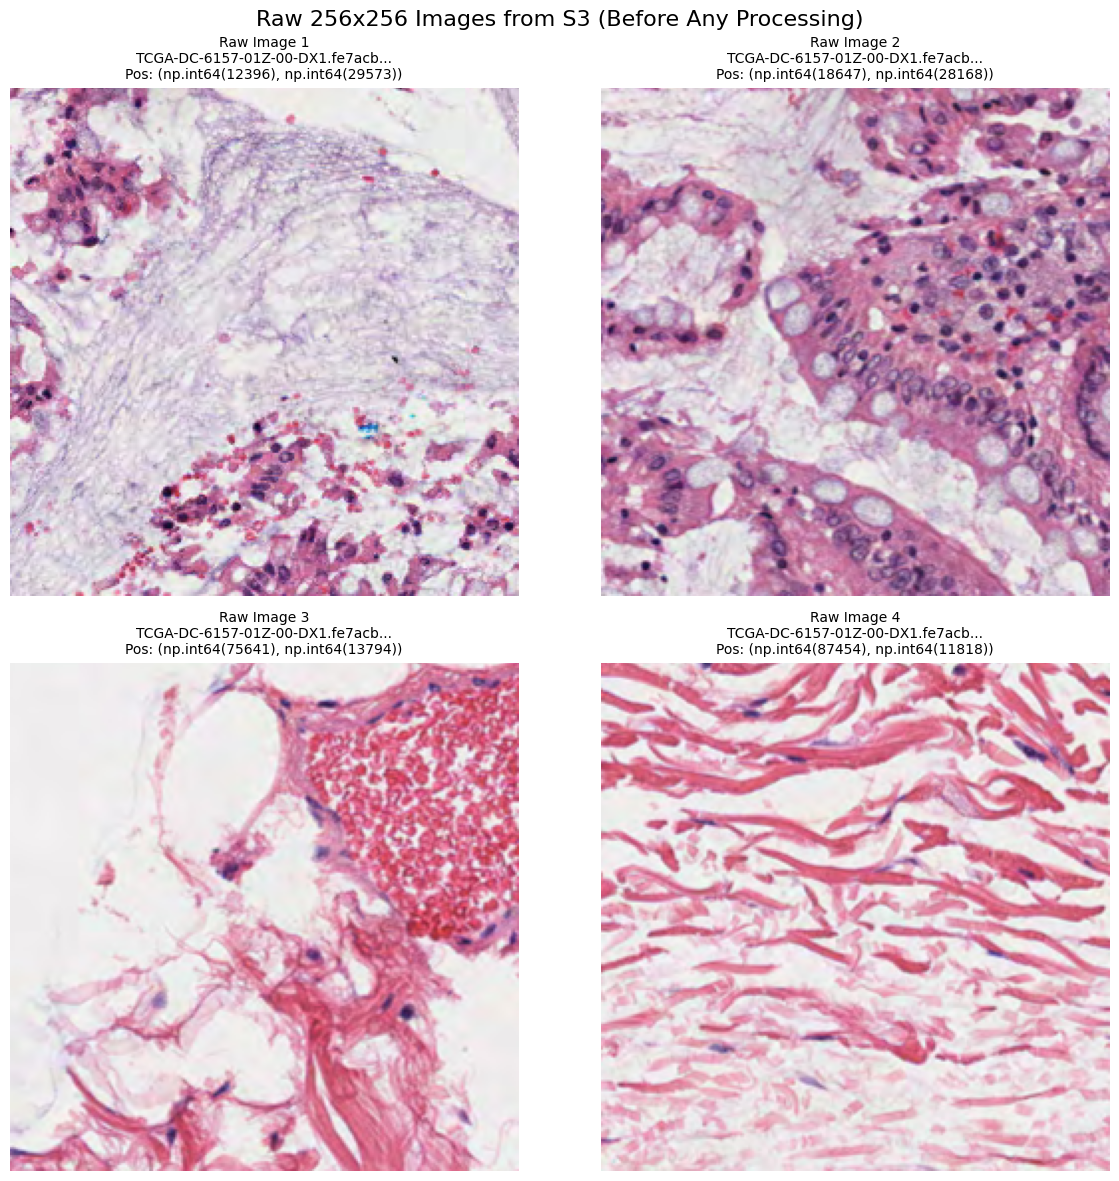

Raw sample metadata:
  Sample 1:
    - Image size: (256, 256)
    - Slide path: /data/TCGA/70b45412-f9c0-4ee9-b1b1-14d51a67eaa3/TCGA-DC-6157-01Z-00-DX1.fe7acbc4-9ccc-48a6-baf1-c72f9c2e79aa.svs
    - Position: (np.int64(12396), np.int64(29573))
    - Level: 1
    - Magnification: 2.0
    - Slide ID: TCGA-DC-6157-01Z-00-DX1.fe7acbc4-9ccc-48a6-baf1-c72f9c2e79aa

  Sample 2:
    - Image size: (256, 256)
    - Slide path: /data/TCGA/70b45412-f9c0-4ee9-b1b1-14d51a67eaa3/TCGA-DC-6157-01Z-00-DX1.fe7acbc4-9ccc-48a6-baf1-c72f9c2e79aa.svs
    - Position: (np.int64(18647), np.int64(28168))
    - Level: 1
    - Magnification: 2.0
    - Slide ID: TCGA-DC-6157-01Z-00-DX1.fe7acbc4-9ccc-48a6-baf1-c72f9c2e79aa

  Sample 3:
    - Image size: (256, 256)
    - Slide path: /data/TCGA/70b45412-f9c0-4ee9-b1b1-14d51a67eaa3/TCGA-DC-6157-01Z-00-DX1.fe7acbc4-9ccc-48a6-baf1-c72f9c2e79aa.svs
    - Position: (np.int64(75641), np.int64(13794))
    - Level: 1
    - Magnification: 2.0
    - Slide ID: TCGA-DC-6157-01Z-0

In [9]:
# Visualize raw 256x256 images loaded from S3 (before any processing)
print("=== RAW IMAGES FROM S3 ===")

# Create a separate dataset WITHOUT transforms to see raw images
raw_dataset = ld.StreamingDataset(
    's3://sophont/paul/data/litTCGA', 
    storage_options=storage_options, 
    shuffle=False,     # Use False for consistent comparison
    drop_last=False,
    transform=None     # No transforms - raw images only
)

# Get a few raw samples
raw_samples = []
raw_iter = iter(raw_dataset)
for i in range(4):
    raw_samples.append(next(raw_iter))

# Visualize raw images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle('Raw 256x256 Images from S3 (Before Any Processing)', fontsize=16)

for i in range(4):
    row = i // 2
    col = i % 2
    
    sample = raw_samples[i]
    image = sample['image']
    slide_id = sample['slide_id']
    position = sample['position']
    
    axes[row, col].imshow(image)
    axes[row, col].set_title(f'Raw Image {i+1}\n{slide_id[:30]}...\nPos: {position}', fontsize=10)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Show metadata for raw samples
print("Raw sample metadata:")
for i, sample in enumerate(raw_samples):
    print(f"  Sample {i+1}:")
    print(f"    - Image size: {sample['image'].size}")
    print(f"    - Slide path: {sample['slide_path']}")
    print(f"    - Position: {sample['position']}")
    print(f"    - Level: {sample['level']}")
    print(f"    - Magnification: {sample['magnification']}")
    print(f"    - Slide ID: {sample['slide_id']}")
    print()

In [10]:
# Visualization functions updated for complete pipeline
def denormalize_tensor(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Denormalize a tensor image for visualization"""
    if tensor.dtype == torch.half:
        tensor = tensor.float()  # Convert from half to float for processing
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean

def tensor_to_pil(tensor):
    """Convert tensor to PIL Image for visualization"""
    if tensor.dtype == torch.half:
        tensor = tensor.float()  # Convert from half to float
    # Clamp values to [0, 1] and convert to numpy
    tensor = torch.clamp(tensor, 0, 1)
    numpy_img = tensor.permute(1, 2, 0).numpy()
    return Image.fromarray((numpy_img * 255).astype(np.uint8))

def visualize_masks(masks, n_tokens_side):
    """Visualize iBOT masks as 2D grids"""
    batch_size = masks.shape[0]
    fig, axes = plt.subplots(1, min(batch_size, 4), figsize=(16, 4))
    if batch_size == 1:
        axes = [axes]
    
    fig.suptitle('iBOT Masks (White=Masked, Black=Visible)', fontsize=14)
    
    for i in range(min(batch_size, 4)):
        mask = masks[i].float().view(n_tokens_side, n_tokens_side)
        axes[i].imshow(mask.numpy(), cmap='gray', vmin=0, vmax=1)
        axes[i].set_title(f'Sample {i+1}\nMasked: {mask.sum().item():.0f}/{n_tokens_side**2}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

print("Visualization functions updated for fp16 and masking")

Visualization functions updated for fp16 and masking


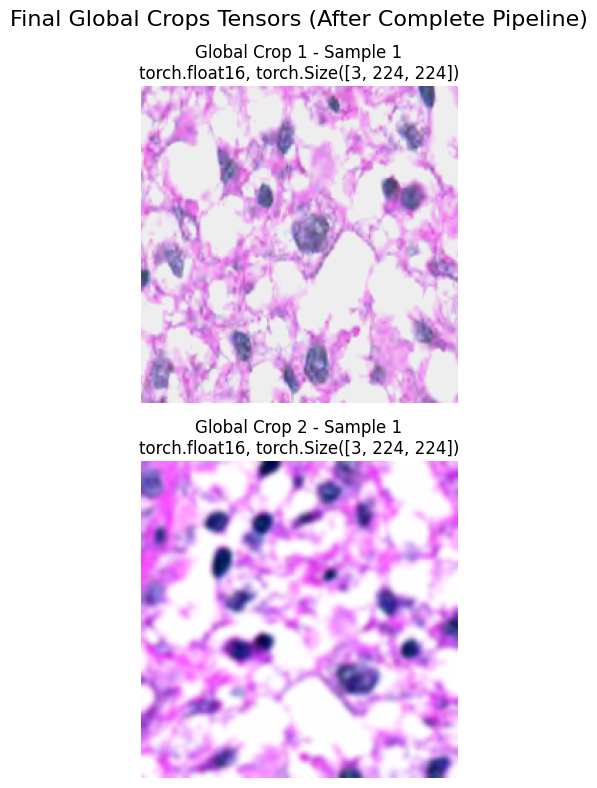

Global crops tensor info:
  Shape: torch.Size([2, 3, 224, 224]) (batch_size*2, C, H, W)
  Dtype: torch.float16
  Value range: [-2.066, 2.641]
  Mean: 1.728, Std: 0.855


In [11]:
# Visualize the final tensors that go into the model
if 'collated_global_crops' in batch:
    global_crops = batch['collated_global_crops']
    batch_size = global_crops.shape[0] // 2  # 2 global crops per sample
    
    fig, axes = plt.subplots(2, min(batch_size, 4), figsize=(16, 8))
    fig.suptitle('Final Global Crops Tensors (After Complete Pipeline)', fontsize=16)
    
    if batch_size == 1:
        axes = axes.reshape(2, 1)
    
    for i in range(min(batch_size, 4)):
        # First global crop
        crop1 = global_crops[i*2]  
        crop1_denorm = denormalize_tensor(crop1)
        axes[0, i].imshow(tensor_to_pil(crop1_denorm))
        axes[0, i].set_title(f'Global Crop 1 - Sample {i+1}\n{crop1.dtype}, {crop1.shape}')
        axes[0, i].axis('off')
        
        # Second global crop
        crop2 = global_crops[i*2 + 1]
        crop2_denorm = denormalize_tensor(crop2)  
        axes[1, i].imshow(tensor_to_pil(crop2_denorm))
        axes[1, i].set_title(f'Global Crop 2 - Sample {i+1}\n{crop2.dtype}, {crop2.shape}')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Global crops tensor info:")
    print(f"  Shape: {global_crops.shape} (batch_size*2, C, H, W)")
    print(f"  Dtype: {global_crops.dtype}")
    print(f"  Value range: [{global_crops.min():.3f}, {global_crops.max():.3f}]")
    print(f"  Mean: {global_crops.float().mean():.3f}, Std: {global_crops.float().std():.3f}")

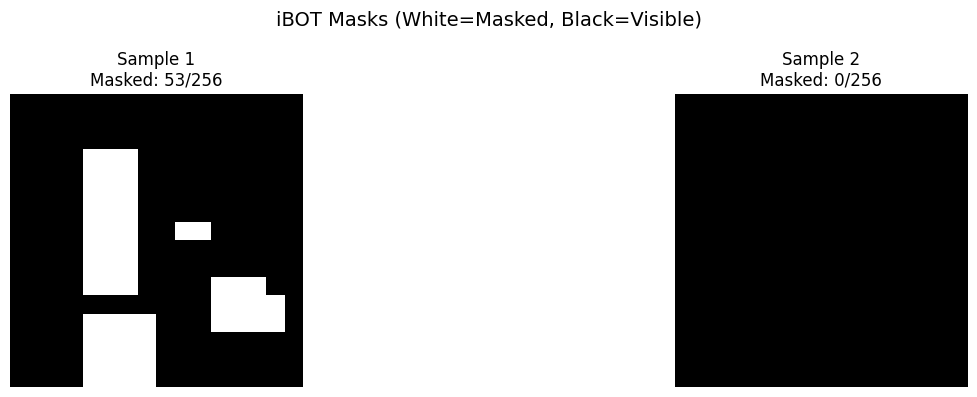

Mask statistics:
  Shape: torch.Size([2, 256])
  Dtype: torch.bool
  Total patches per image: 256
  Patches per side: 16
  Sample 1: 20.7% masked (53/256 patches)
  Sample 2: 0.0% masked (0/256 patches)


In [12]:
# Visualize the iBOT masks
if 'collated_masks' in batch:
    n_tokens_side = int(n_tokens**0.5)  # sqrt of total patches
    visualize_masks(batch['collated_masks'], n_tokens_side)
    
    # Show mask statistics
    masks = batch['collated_masks']
    print(f"Mask statistics:")
    print(f"  Shape: {masks.shape}")
    print(f"  Dtype: {masks.dtype}")
    print(f"  Total patches per image: {n_tokens}")
    print(f"  Patches per side: {n_tokens_side}")
    
    for i in range(min(4, masks.shape[0])):
        mask_ratio = masks[i].float().mean().item()
        print(f"  Sample {i+1}: {mask_ratio:.1%} masked ({masks[i].sum():.0f}/{n_tokens} patches)")
else:
    print("No masks found - masking may be disabled")

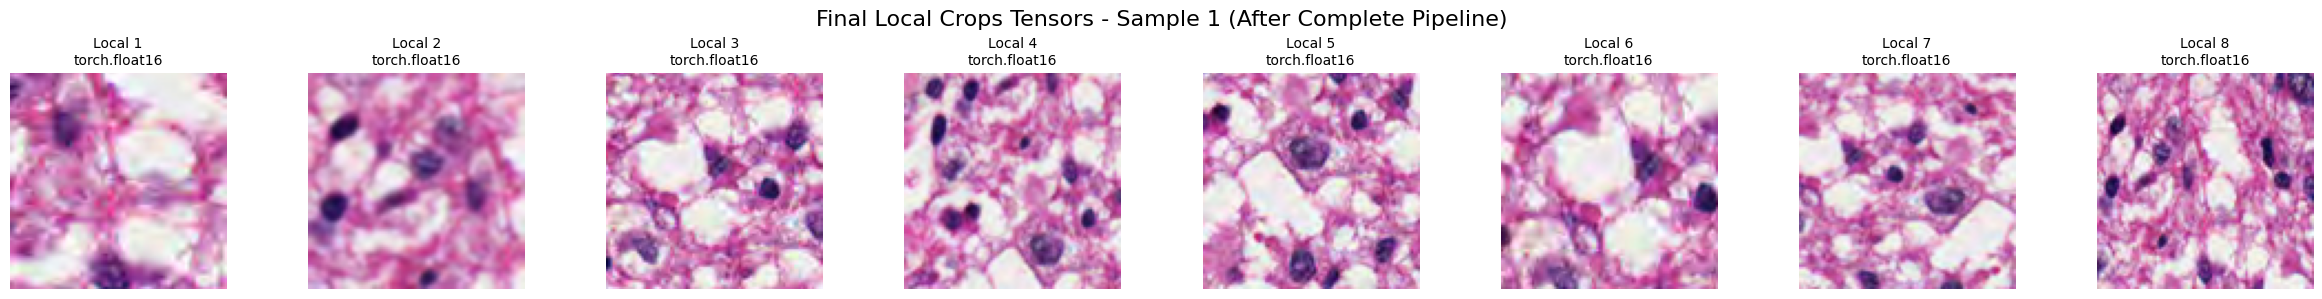

Local crops tensor info:
  Shape: torch.Size([8, 3, 98, 98]) (batch_size*8, C, H, W)
  Dtype: torch.float16
  Value range: [-2.018, 2.641]
  Mean: 1.152, Std: 0.895


In [13]:
# Visualize local crops (more than before due to batching)
if 'collated_local_crops' in batch:
    local_crops = batch['collated_local_crops']
    batch_size = local_crops.shape[0] // 8  # 8 local crops per sample
    
    # Show first 8 local crops from first sample
    fig, axes = plt.subplots(1, 8, figsize=(24, 3))
    fig.suptitle('Final Local Crops Tensors - Sample 1 (After Complete Pipeline)', fontsize=16)
    
    for i in range(8):
        crop = local_crops[i]  # First sample's local crops
        crop_denorm = denormalize_tensor(crop)
        axes[i].imshow(tensor_to_pil(crop_denorm))
        axes[i].set_title(f'Local {i+1}\n{crop.dtype}', fontsize=10)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Local crops tensor info:")
    print(f"  Shape: {local_crops.shape} (batch_size*8, C, H, W)")
    print(f"  Dtype: {local_crops.dtype}")
    print(f"  Value range: [{local_crops.min():.3f}, {local_crops.max():.3f}]")
    print(f"  Mean: {local_crops.float().mean():.3f}, Std: {local_crops.float().std():.3f}")

In [14]:
# Final summary: Compare with training loop
print("=== COMPLETE PIPELINE SUMMARY ===")
print("This batch now matches EXACTLY what the training loop receives:")
print("")

print("1. DATA FLOW:")
print("   S3 → StreamingDataset → extract_and_transform → collate_data_and_cast → Model")
print("")

print("2. TENSOR FORMATS:")
for key, tensor in batch.items():
    if isinstance(tensor, torch.Tensor):
        print(f"   {key}: {tensor.shape} ({tensor.dtype})")
print("")

print("3. TRAINING LOOP USAGE:")
print("   # This is exactly what gets passed to model.forward_backward()")
print("   loss_dict = model.forward_backward(data, teacher_temp=teacher_temp)")
print("   # Where 'data' is the batch we just created")
print("")

print("4. KEY DIFFERENCES FROM ORIGINAL NOTEBOOK:")
print("   ✓ Added iBOT masking (collated_masks)")
print("   ✓ Added proper collation (collate_data_and_cast)")  
print("   ✓ Uses torch.half (fp16) instead of float32")
print("   ✓ Proper shuffle=True, drop_last=True")
print("   ✓ Uses exact config values from vits14_reg4.yaml")
print("")

print("5. VERIFICATION:")
actual_batch_size = batch['collated_global_crops'].shape[0] // 2
print(f"   Batch size: {actual_batch_size}")
print(f"   Total global crops: {batch['collated_global_crops'].shape[0]} (2 per sample)")
print(f"   Total local crops: {batch['collated_local_crops'].shape[0]} (8 per sample)")
print(f"   Masks: {batch['collated_masks'].shape[0]} (1 per sample)")

if batch['collated_masks'].shape[0] == actual_batch_size:
    print("   ✓ All dimensions consistent")
else:
    print("   ✗ Dimension mismatch!")

=== COMPLETE PIPELINE SUMMARY ===
This batch now matches EXACTLY what the training loop receives:

1. DATA FLOW:
   S3 → StreamingDataset → extract_and_transform → collate_data_and_cast → Model

2. TENSOR FORMATS:
   collated_global_crops: torch.Size([2, 3, 224, 224]) (torch.float16)
   collated_local_crops: torch.Size([8, 3, 98, 98]) (torch.float16)
   collated_masks: torch.Size([2, 256]) (torch.bool)
   mask_indices_list: torch.Size([53]) (torch.int64)
   masks_weight: torch.Size([53]) (torch.float32)
   n_masked_patches: torch.Size([1]) (torch.int64)

3. TRAINING LOOP USAGE:
   # This is exactly what gets passed to model.forward_backward()
   loss_dict = model.forward_backward(data, teacher_temp=teacher_temp)
   # Where 'data' is the batch we just created

4. KEY DIFFERENCES FROM ORIGINAL NOTEBOOK:
   ✓ Added iBOT masking (collated_masks)
   ✓ Added proper collation (collate_data_and_cast)
   ✓ Uses torch.half (fp16) instead of float32
   ✓ Proper shuffle=True, drop_last=True
   ✓ U

In [42]:
# # Optional: Test with the actual model forward pass
# print("=== TESTING MODEL FORWARD PASS ===")

# from dinov2.train.ssl_meta_arch import SSLMetaArch
# from dinov2.train.train import get_args_parser
# from dinov2.utils.config import setup

# # Load config and model
# args = get_args_parser().parse_args(['--config-file', './dinov2/configs/train/vits14_reg4.yaml'])
# cfg = setup(args)

# print("✓ Config loaded successfully")
# print(f"  - Batch size per GPU: {cfg.train.batch_size_per_gpu}")
# print(f"  - Patch size: {cfg.student.patch_size}")
# print(f"  - Local crops size: {cfg.crops.local_crops_size}")

# # Uncomment below to actually load the model (requires GPU)
# model = SSLMetaArch(cfg).to(torch.device('cuda'))
# model.train()
# teacher_temp = cfg.teacher.teacher_temp
# loss_dict = model.forward_backward(batch, teacher_temp=teacher_temp)
# print(f'✓ Forward pass successful! Loss dict: {list(loss_dict.keys())}')

# print("✓ Config verification complete - pipeline matches training setup")

In [43]:
# Test a few batches to see variation in masking
print("=== TESTING MULTIPLE BATCHES ===")
print("Testing mask variation across batches:")

for batch_num in range(3):
    test_batch = next(iter(data_loader))
    masks = test_batch['collated_masks']
    
    mask_ratios = []
    for i in range(min(3, masks.shape[0])):
        ratio = masks[i].float().mean().item()
        mask_ratios.append(ratio)
    
    avg_ratio = sum(mask_ratios) / len(mask_ratios)
    print(f"Batch {batch_num + 1}: Avg mask ratio = {avg_ratio:.1%} (samples: {[f'{r:.1%}' for r in mask_ratios]})")

print("")
print("This variation confirms the masking is working correctly!")
print(f"Expected range: {CONFIG['mask_ratio_min_max'][0]:.1%} - {CONFIG['mask_ratio_min_max'][1]:.1%}")
print(f"Sample probability: {CONFIG['mask_sample_probability']:.1%}")

=== TESTING MULTIPLE BATCHES ===
Testing mask variation across batches:
Batch 1: Avg mask ratio = 14.3% (samples: ['28.5%', '0.0%'])
Batch 2: Avg mask ratio = 24.4% (samples: ['0.0%', '48.8%'])
Batch 3: Avg mask ratio = 7.2% (samples: ['0.0%', '14.5%'])

This variation confirms the masking is working correctly!
Expected range: 10.0% - 50.0%
Sample probability: 50.0%
